# Modeling and Simulation in Python

Insulin minimal model

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

The return value from `interpolate` is a function.

### The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

**Exercise:**  Write a version of `make_system` that takes the parameters of this model, `I0`, `k`, `gamma`, and `G_T` as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_simulation` or `run_odeint`.

Use it to make a `System` object with the following parameters:

In [3]:
params = Params(I0 = 360,
                k = 0.25,
                gamma = 0.004,
                G_T = 80)

,values
I0,360.000
k,0.250
gamma,0.004
G_T,80.000


In [4]:
# Solution

def make_system(params, data):
    I0, k, gamma, G_T = params
    init = State(I=I0)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    system = System(params, init=init,
                    G=interpolate(data.glucose),
                    t_0=t_0, t_end=t_end)
    return system

In [5]:
# Solution

system = make_system(params, data)

,values
I0,360
k,0.25
gamma,0.004
G_T,80
init,I 360.0 dtype: float64
G,<scipy.interpolate.interpolate.interp1d object...
t_0,0
t_end,182


**Exercise:** Write a slope function that takes state, t, system as parameters and returns the derivative of `I` with respect to time.  Test your function with the initial condition $I(0)=360$.

In [6]:
# Solution

def slope_func(state, t, system):
    I = state
    unpack(system)
    
    dIdt = - k * I + gamma * (G(t) - G_T) * t
    
    return dIdt

In [8]:
# Solution

slope_func(system.init, system.t_0, system)

I   -90.0
dtype: float64

**Exercise:** Run `run_odeint` with your `System` object and slope function, and plot the results, along with the measured insulin levels.

In [9]:
# Solution

results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details

,values
sol,None
t_events,[]
nfev,314
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


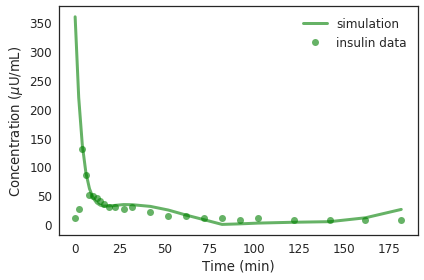

In [10]:
# Solution

plot(results, 'g-', label='simulation')
plot(data.insulin, 'go', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, run it, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did in a previous exercise, you might want to drop the errors for times prior to `t=8`.

In [11]:
# Solution

def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    actual: array of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_ode_solver(system, slope_func, t_eval=data.index)

    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return TimeSeries(errors.loc[8:])

In [12]:
# Solution

error_func(params, data)

I0       360.000
k          0.250
gamma      0.004
G_T       80.000
dtype: float64


,values
8,10.679284
10,-3.230156
12,-7.936756
14,-8.007716
16,-3.570965
19,1.815372
22,2.570822
27,7.101640
32,3.815164
42,8.932695


**Exercise:** Use `fit_leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [13]:
# Solution

best_params = fit_leastsq(error_func, params, data)

[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.60000005e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000004e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000006e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000000e-03 8.00000012e+01]
[3.60121584e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60060792e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60028739e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.6001379e+02 2.5000000e-01 4.0000000e-03 8.0000000e+01]
[3.60006945e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60003459e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60001286e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60001291e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60001286e+02 2.50000004e-01 4.00000000e-03 8.00000000e+01]
[3.60001286e+02 2.50000000e-01 4.00000006e-03 8.00000000e+01]
[3.60001286e+02 2.50000000e-01 4.0

,values
I0,360.001015
k,0.250000
gamma,0.004000
G_T,80.000000


In [14]:
# Solution

system = make_system(best_params, data)

,values
I0,360.001
k,0.25
gamma,0.004
G_T,80
init,I 360.001015 dtype: float64
G,<scipy.interpolate.interpolate.interp1d object...
t_0,0
t_end,182


In [15]:
# Solution

results, details = run_ode_solver(system, slope_func, t_eval=data.index)
details

,values
sol,None
t_events,[]
nfev,314
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


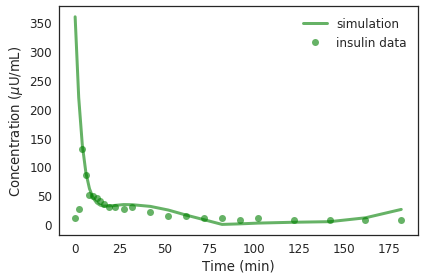

In [16]:
# Solution

plot(results, 'g-', label='simulation')
plot(data.insulin, 'go', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 290.  For $G_b$ and $I_b$, use the inital measurements from the data.


In [17]:
# Solution

I0, k, gamma, G_T = best_params

In [18]:
# Solution

I_max = data.insulin.max()
Ib = data.insulin[0]
I_max, Ib

(130, 11)

In [19]:
# Solution

# The value of G0 is the best estimate from the glucose model
G0 = 289
Gb = data.glucose[0]
G0, Gb

(289, 92)

In [20]:
# Solution

phi_1 = (I_max - Ib) / k / (G0 - Gb)
phi_1

2.416243654822335

In [21]:
# Solution

phi_2 = gamma * 1e4
phi_2

40.0